In [1]:
!pip3 install -U segmentation-models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 6.3 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip /content/drive/MyDrive/ocelot2023_v0.1.2.zip

Archive:  /content/drive/MyDrive/ocelot2023_v0.1.2.zip
   creating: ocelot2023_v0.1.2/
   creating: ocelot2023_v0.1.2/images/
  inflating: ocelot2023_v0.1.2/metadata.json  
   creating: ocelot2023_v0.1.2/annotations/
   creating: ocelot2023_v0.1.2/images/train/
   creating: ocelot2023_v0.1.2/annotations/train/
   creating: ocelot2023_v0.1.2/images/train/tissue/
   creating: ocelot2023_v0.1.2/images/train/cell/
   creating: ocelot2023_v0.1.2/annotations/train/tissue/
   creating: ocelot2023_v0.1.2/annotations/train/cell/
  inflating: ocelot2023_v0.1.2/images/train/tissue/189.jpg  
  inflating: ocelot2023_v0.1.2/images/train/tissue/162.jpg  
  inflating: ocelot2023_v0.1.2/images/train/tissue/176.jpg  
  inflating: ocelot2023_v0.1.2/images/train/tissue/348.jpg  
  inflating: ocelot2023_v0.1.2/images/train/tissue/360.jpg  
  inflating: ocelot2023_v0.1.2/images/train/tissue/374.jpg  
  inflating: ocelot2023_v0.1.2/images/train/tissue/228.jpg  
  inflating: ocelot2023_v0.1.2/images/train/tis

In [4]:
import json
with open('/content/ocelot2023_v0.1.2/metadata.json') as file:
    data = json.load(file)


In [6]:
#data

#Importing the Images and Masks

In [7]:
#Handling Data in Runtime so the original data doesn't get messed up:

import shutil

src= '/content/ocelot2023_v0.1.2'
dest='/content/ocelot2023'

shutil.copytree(src,dest)



'/content/ocelot2023'

In [8]:
import os
import cv2
import numpy as np


#image_folder = '/content/drive/MyDrive/sa_rest/images'
#mask_folder = '/content/drive/MyDrive/sa_rest/masks'

image_folder = '/content/ocelot2023/images/train/tissue'
mask_folder = '/content/ocelot2023/annotations/train/tissue'

image_files = os.listdir(image_folder)
mask_files = os.listdir(mask_folder)

images = []
masks  = []

for filename in image_files:
    img_path = os.path.join(image_folder, filename)
    img = cv2.imread(img_path)
    images.append(img)

for filename in mask_files:
    mask_path = os.path.join(mask_folder, filename)
    mask = cv2.imread(mask_path)  # Read as grayscale
    # mask = np.expand_dims(mask, axis = -1)
    masks.append(mask)

images = np.array(images)
masks = np.array(masks)

#Testing if loaded and plotting

In [9]:
from google.colab.patches import cv2_imshow
images[10].shape, masks[10].shape

((1024, 1024, 3), (1024, 1024, 3))

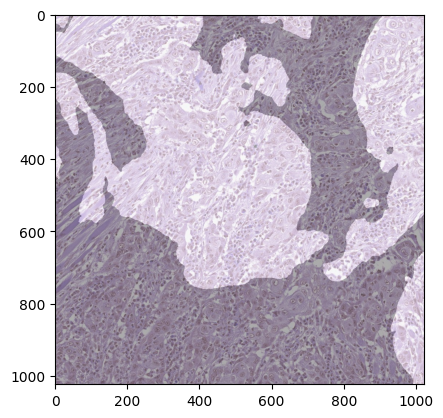

In [10]:
import matplotlib.pyplot as plt
img=images[80]
ann=masks[80]
weighted_sum = cv2.addWeighted(img, 0.4, ann*127, 0.6, 0)
plt.imshow(weighted_sum)


#Relabelling Classes:

In [12]:
import os
from PIL import Image
import numpy as np

# Directory of mask images
mask_directory = '/content/ocelot2023/annotations/train/tissue'
print(mask_directory)

mask_directory1="/content/mask_updated"
# Iterate through all mask images in the directory
for filename in os.listdir(mask_directory):
    if filename.endswith(".png"):
        # Load the mask image
        mask_image = Image.open(os.path.join(mask_directory, filename))

        # Convert the image to a numpy array for manipulation
        mask_array = np.array(mask_image)

        # Map "UNK" (255) to the background label (0) also Background (0) to 0
        mask_array[mask_array == 1] = 0 #When prediction change to 0
        mask_array[mask_array == 255] = 2 #When Prediction 255

        #Map 'Tumor (2) to 1:
        mask_array[mask_array == 2]=1 #When Prediction 170

        # Convert the modified array back to an image
        modified_image = Image.fromarray(mask_array)

        # Save the modified image with a new filename
        modified_filename = f"{filename}"
        modified_image.save(os.path.join(mask_directory1, modified_filename))


/content/ocelot2023/annotations/train/tissue


In [13]:
import os
import cv2
import numpy as np
from natsort import natsorted

image_folder = '/content/ocelot2023/images/train/tissue'
mask_folder = '/content/mask_updated'

image_files = natsorted(os.listdir(image_folder))
mask_files = natsorted(os.listdir(mask_folder))

images = []
masks = []

for filename in image_files:
    img_path = os.path.join(image_folder, filename)
    img = cv2.imread(img_path)
    images.append(img)

for filename in mask_files:
    mask_path = os.path.join(mask_folder, filename)
    mask = cv2.imread(mask_path)  # Read as grayscale
    masks.append(mask)

images = np.array(images)
masks = np.array(masks)



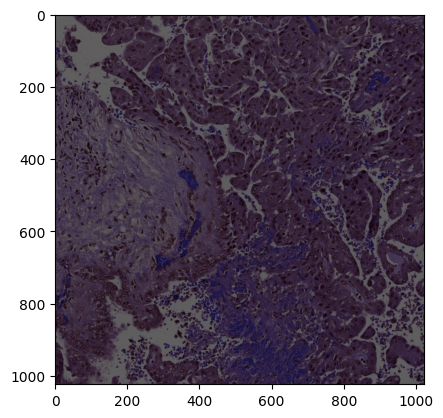

In [14]:
import matplotlib.pyplot as plt
img = images[1]
ann = masks[1]
weighted_sum = cv2.addWeighted(img, 0.4, ann, 0.6, 0)
plt.imshow(weighted_sum)
plt.show()


In [15]:
from google.colab.patches import cv2_imshow
images[10].shape, masks[10].shape


((1024, 1024, 3), (1024, 1024, 3))

#Generating Slides


In [16]:
import numpy as np

def crop_img_msk(img, msk, size, stride):
    # this function crops an image and its corresponding mask using the sliding window technique. Size is the patch size of the sliding window and stride is the stride of the sliding window patches.
    cropped_img = []
    cropped_msk = []
    size_x = img.shape[1]
    size_y = img.shape[0]
    x = np.arange(0, size_x, stride)
    y = np.arange(0, size_y, stride)
    x = [i for i in x if i+size <= size_x]
    y = [i for i in y if i+size <= size_y]
    x.append(size_x-size)
    y.append(size_y-size)
    x = np.unique(x)
    y = np.unique(y)
    for i in x:
        for j in y:
            cropped_img.append(img[j:j+size, i:i+size])
            cropped_msk.append(msk[j:j+size, i:i+size])
    return cropped_img, cropped_msk

In [17]:
import cv2
import math
#from crop_img_msk import crop_img_msk
import numpy as np

def rotation(image, angleInDegrees):
    h, w = image.shape[:2]
    img_c = (w / 2, h / 2)

    rot = cv2.getRotationMatrix2D(img_c, angleInDegrees, 1)

    rad = math.radians(angleInDegrees)
    sin = math.sin(rad)
    cos = math.cos(rad)
    b_w = int((h * abs(sin)) + (w * abs(cos)))
    b_h = int((h * abs(cos)) + (w * abs(sin)))

    rot[0, 2] += ((b_w / 2) - img_c[0])
    rot[1, 2] += ((b_h / 2) - img_c[1])

    outImg = cv2.warpAffine(image, rot, (b_w, b_h), flags=cv2.INTER_LINEAR)
    return outImg

def extract_patches_with_angle(img, msk, size, stride, angle):

    img_rotated = rotation(img, angle)
    msk_rotated = rotation(msk, angle)

    imgs, msks = crop_img_msk(img_rotated, msk_rotated, size, stride)

    idx = [i for i in range(len(msks)) if np.any(msks[i]==0)]

    imgs_wanted = []
    msks_wanted = []
    for i in range(len(imgs)):
        if i not in idx:
            imgs_wanted.append(imgs[i])
            msks_wanted.append(msks[i])

    return imgs_wanted, msks_wanted




#Augmenting Masks

In [18]:
import numpy as np

def aug_imgs_msks_d4(patches, patches_masks):
    # This function augments patches and masks using D4 symmetry of a square.
    # Inputs: patches and patches_masks are lists containing patches and patches_masks.
    # Outputs: aug_patches and aug_patches_masks: are lists containing the augmented patches and masks using D4 symmetry of a sqaure.

    aug_patches = []
    aug_patches_masks = []
    for i in range(len(patches)):
        aug_patches.append(patches[i])
        aug_patches_masks.append(patches_masks[i])

    for i in range(len(patches)):
        aug_patches.append(np.fliplr(patches[i]))
        aug_patches_masks.append(np.fliplr(patches_masks[i]))

    for i in range(len(patches)):
        aug_patches.append(np.flipud(patches[i]))
        aug_patches_masks.append(np.flipud(patches_masks[i]))

    for i in range(len(patches)):
        aug_patches.append(np.rot90(patches[i]))
        aug_patches_masks.append(np.rot90(patches_masks[i]))

    for i in range(len(patches)):
        aug_patches.append(np.rot90(np.rot90(patches[i])))
        aug_patches_masks.append(np.rot90(np.rot90(patches_masks[i])))

    for i in range(len(patches)):
        aug_patches.append(np.rot90(np.rot90(np.rot90(patches[i]))))
        aug_patches_masks.append(np.rot90(np.rot90(np.rot90(patches_masks[i]))))

    for i in range(len(patches)):
        aug_patches.append(np.fliplr(np.rot90(patches[i])))
        aug_patches_masks.append(np.fliplr(np.rot90(patches_masks[i])))

    for i in range(len(patches)):
        aug_patches.append(np.flipud(np.rot90(patches[i])))
        aug_patches_masks.append(np.flipud(np.rot90(patches_masks[i])))

    return aug_patches, aug_patches_masks

#Segmentation Architecture - UNEt with Inception V3


In [19]:
!pip install -U -q segmentation-models
!pip install -q tensorflow==2.2.1
!pip install -q keras==2.5
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

ERROR: Could not find a version that satisfies the requirement tensorflow==2.2.1 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2)
ERROR: No matching distribution found for tensorflow==2.2.1
ERROR: Could not find a version that satisfies the requirement keras==2.5 (from versions: 0.2.0, 0.3.0, 0.3.1, 0.3.2, 0.3.3, 1.0.0, 1.0.1, 1.0.2, 1.0.3, 1.0.4, 1.0.5, 1.0.6, 1.0.7, 1.0.8, 1.1.0, 1.1.1, 1.1.2, 1.2.0, 1.2.1, 1.2.2, 2.0.0, 2.0.1, 2.0.2, 2.0.3, 2.0.4, 2.0.5, 2.0.6, 2.0.7, 2.0.8, 2.0.9, 2.1.0, 2.1.1, 2.1.2, 2.1.3, 2.1.4, 2.1.5, 2.1.6, 2.2.0, 2.2.1, 2.2.2, 2.2.3, 2.2.4, 2.2.5, 2.3.0, 2.3.1, 2.4.0, 2.4.1, 2.4.2, 2.4.3, 2.5.0rc0, 2.6.0rc0, 2.6.0rc1, 2.6.0rc2, 2.6.0rc3, 2.6.0, 2.7.0rc0, 2.7.0rc2, 2.7.0, 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.9.0rc0, 2.9.

In [20]:
# this function creates the segmentation model by adding a dropout layer before the output softmax layer.
# different backbones can be used. num_classes is the number of classes to segment. One can change the input patch size as well.
# model_dp is the segmentation model to train. preprocess_input is the preprocessing input for the input patches to the model. In case of InceptionV3 this function
# rescales the input patches from [0,256] to [-1,1].

import tensorflow
import segmentation_models as sm
sm.set_framework('tf.keras')

BACKBONE = 'inceptionv3'
activation='softmax'
encoder_freeze = False
num_classes = 3

preprocess_input = sm.get_preprocessing(BACKBONE)
def model(dropout_value):
    preprocess_input = sm.get_preprocessing(BACKBONE)
    model = sm.Unet(BACKBONE,
                    input_shape = (256,256,3),
                    encoder_weights=None,
                    classes=num_classes,
                    activation=activation,
                    encoder_freeze = encoder_freeze)
    model.summary()
    model_input = model.input
    model_output = model.get_layer('final_conv').output
    model_output = tensorflow.keras.layers.Dropout(dropout_value)(model_output)
    output = tensorflow.keras.layers.Activation(activation, name=activation)(model_output)
    model_dp = tensorflow.keras.models.Model(model_input, output)
    return model_dp, preprocess_input

#Modelling

In [21]:


########## Extracting Patches from images and masks ########
########## Extracting Patches from images and masks ########
########## Extracting Patches from images and masks ########

# temporairly changing mask values of 0 to 3 for patch extraction


#from crop_img_msk import crop_img_msk
patches = []
patches_masks = []
for i in range(len(images)):
    img_cropped,msk_cropped = crop_img_msk(images[i], masks[i], size = 256, stride = 128)
    for j in img_cropped:
        patches.append(j)
    for j in msk_cropped:
        patches_masks.append(j)
del img_cropped,msk_cropped,i,j




In [22]:
################## Shuffling Patches #######################
################## Shuffling Patches #######################
################## Shuffling Patches #######################
idx = np.random.RandomState(seed=42).permutation(np.arange(0,len(patches)))
patches = [patches[i] for i in idx]
patches_masks = [patches_masks[i] for i in idx]
del idx

################## Augmenting Patches #######################
################## Augmenting Patches #######################
################## Augmenting Patches #######################
#from aug_imgs_msks_d4 import aug_imgs_msks_d4
patches, patches_masks = aug_imgs_msks_d4(patches,patches_masks)

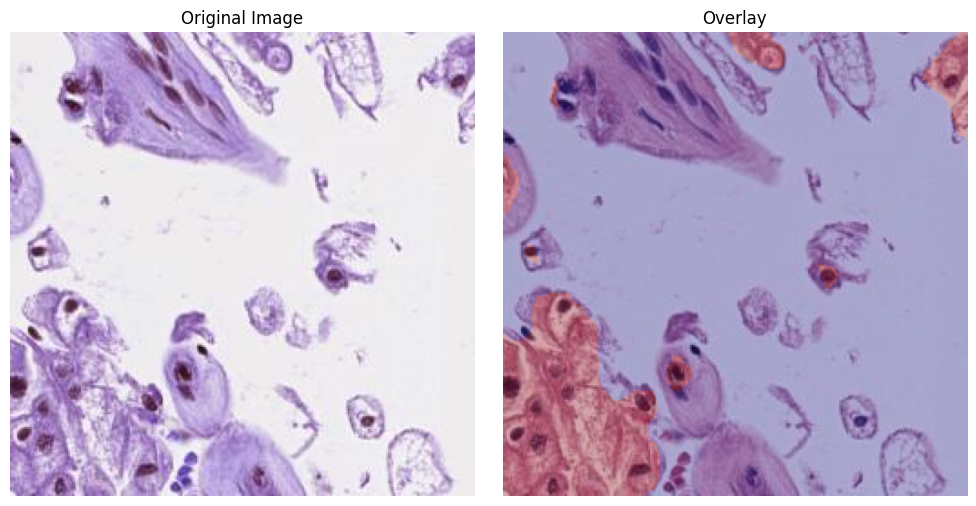

In [23]:
import matplotlib.pyplot as plt
import cv2

img = patches[31]
ann = patches_masks[31]

# Normalize the mask to the range [0, 255]
ann_normalized = cv2.normalize(ann, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

# Apply a color map to the normalized mask
ann_colormap = cv2.applyColorMap(ann_normalized, cv2.COLORMAP_JET)

# Combine the original image and the colorized mask using alpha blending
overlay = cv2.addWeighted(img, 0.7, ann_colormap, 0.3, 0)

# Create a subplot grid with two columns
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Display the original image in the first subplot
axs[0].imshow(img)
axs[0].set_title('Original Image')

# Display the overlay in the second subplot
axs[1].imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
axs[1].set_title('Overlay')

# Remove the axis labels
for ax in axs:
    ax.axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
########################## Training Seg Model ##########################
########################## Training Seg Model ##########################
########################## Training Seg Model ##########################
from tensorflow.keras.utils import to_categorical
def image_mask_generator(imgs, msks, batch_size):
    L = len(imgs)
    while True:
        batch_start = 0
        batch_end = batch_size
        while batch_start < L:
            limit = min(batch_end, L)
            temp_imgs = []
            temp_msks = []
            for i in range(batch_start, limit):
                temp_imgs.append(imgs[i])
                temp_msks.append(msks[i])
            temp_imgs = [preprocess_input(i) for i in temp_imgs]
            temp_msks = [to_categorical(i, num_classes=3) for i in temp_msks]
            temp_imgs = np.array(temp_imgs)
            temp_msks = np.array(temp_msks)
            temp_msks = temp_msks[:, :, :, 2]  # Extract the second channel (index 1) from the label masks
            temp_msks = np.expand_dims(temp_msks, axis=-1)  # Add a single channel dimension
            yield (temp_imgs, temp_msks)  # a tuple with two numpy arrays with batch_size samples
            batch_start += batch_size
            batch_end += batch_size


import os
import random
import tensorflow
import segmentation_models as sm
#from segmentation_model import model
model, preprocess_input = model(dropout_value=0.4)



#class_weights = np.array([1.6, 1, 0.76])
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)
metrics = sm.metrics.IOUScore()
model.compile(tensorflow.keras.optimizers.Adam(learning_rate=0.0001), total_loss, metrics=metrics)

epochs = 10
batch_size = 32
os.environ['PYTHONHASHSEED'] = str(12321)
random.seed(12321)
np.random.seed(12321)
tensorflow.random.set_seed(12321)
filepath = "/content/drive/MyDrive/inceptionv3_None Weight_CHANNEL_all_{epoch:02d}.hdf5"
my_callbacks = [
    tensorflow.keras.callbacks.ModelCheckpoint(filepath, verbose=0, save_best_only=False, save_weights_only = True)
    ]

model.fit(image_mask_generator(patches, patches_masks, batch_size),
          epochs = epochs,
          steps_per_epoch = len(patches)//batch_size,
          verbose = 1,
          callbacks = my_callbacks)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             